In [1]:
import numpy as np
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import wandb

In [2]:
%load_ext autoreload
%autoreload 2
from models import VisualEncoder, VisualDecoder

In [3]:
images = np.load('data/images.npy') # путь до картинок из иглу
images = np.transpose(images,(0,3,1,2))
images = torch.Tensor(images)
train_dataset = images
train_set, val_set = torch.utils.data.random_split(train_dataset, [100000, 13873])
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=False, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

## Training AtariCNN

In [6]:
class Autoencoder(nn.Module):
    def __init__(self,
               encoder_class : object = VisualEncoder,
               decoder_class : object = VisualDecoder):
        super().__init__()
        self.encoder = encoder_class()
        self.decoder = decoder_class()
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode
model = Autoencoder()
model.to('cuda')

total_params = sum(p.numel() for p in model.encoder.parameters() if p.requires_grad)
print('Total params:', total_params)

Total params: 600736


In [ ]:
config_defaults = {
    'epochs': 50,
    'batch_size': 1024,
    'learning_rate': 1e-3,
    'optimizer': 'adam',
    'scheduler_step_size': 30,
    'scheduler_gamma': 0.5
}

wandb.init(project='AutoEncoder', entity='neuro_ai', name='AtariCNN', config=config_defaults)
config = wandb.config
optimizer = optim.Adam(model.parameters(), config.learning_rate)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=config.scheduler_step_size, 
                                            gamma=config.scheduler_gamma)

for epoch in range(config.epochs):
    #train
    model.train()
    train_loss = []
    for data in train_loader:
        data /= 255
        data = data.to('cuda')
        predict = model(data)
        loss = criterion(predict, data)    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    train_loss = np.array(train_loss).mean()
    
    #evaluate
    model.eval()
    val_loss = []
    for data in val_loader:
        data /= 255
        data = data.to('cuda')
        predict = model(data)
        loss = criterion(predict, data)
        val_loss.append(loss.item())
    val_loss = np.array(val_loss).mean()
    scheduler.step()
    wandb.log({"train_loss":train_loss, 'val_loss': val_loss})

In [ ]:
torch.save(model.encoder.state_dict(), 'models/AtariCNN/encoder_weigths.pth')
torch.save(model.decoder.state_dict(), 'models/AtariCNN/decoder_weigths.pth')

##  AnnaCNN 

In [13]:
class VisualEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=8, stride=4, padding=0),  
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0), 
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0), 
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(), 
            nn.Conv2d(64, 512, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

    def forward(self, x):
        return self.cnn(x)

class VisualDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.ConvTranspose2d(512, 64, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=0, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=8, stride=4, padding=0),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.reshape(x.shape[0], 512, 1, 1)
        x = self.cnn(x)
        return x 

In [14]:
class Autoencoder(nn.Module):
    def __init__(self,
               encoder_class : object = VisualEncoder,
               decoder_class : object = VisualDecoder):
        super().__init__()
        self.encoder = encoder_class()
        self.decoder = decoder_class()
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode
model = Autoencoder()
model.to('cuda')

total_params = sum(p.numel() for p in model.encoder.parameters() if p.requires_grad)
print('Total params:', total_params)

Total params: 244448


In [ ]:
config_defaults = {
    'epochs': 100,
    'batch_size': 1024,
    'learning_rate': 1e-3,
    'optimizer': 'adam',
    'scheduler_step_size': 30,
    'scheduler_gamma': 0.5
}

wandb.init(project='AutoEncoder', entity='neuro_ai', name='AnnaCNN', config=config_defaults)
config = wandb.config
optimizer = optim.Adam(model.parameters(), config.learning_rate)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=config.scheduler_step_size, 
                                            gamma=config.scheduler_gamma)

for epoch in range(config.epochs):
    #train
    model.train()
    train_loss = []
    for data in train_loader:
        data /= 255
        data = data.to('cuda')
        predict = model(data)
        loss = criterion(predict, data)    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    train_loss = np.array(train_loss).mean()
    
    #evaluate
    model.eval()
    val_loss = []
    for data in val_loader:
        data /= 255
        data = data.to('cuda')
        predict = model(data)
        loss = criterion(predict, data)
        val_loss.append(loss.item())
    val_loss = np.array(val_loss).mean()
    scheduler.step()
    wandb.log({"train_loss":train_loss, 'val_loss': val_loss})

train_loss,0.02454
val_loss,0.02426


train_loss,█▂▂▁▁▁▁▁
val_loss,█▄▃▃▂▂▁▁


In [16]:
torch.save(model.encoder.state_dict(), 'models/AnnaCNN/encoder_weigths.pth')
torch.save(model.decoder.state_dict(), 'models/AnnaCNN/decoder_weigths.pth')

##  AlinaCNN 

In [17]:
class VisualEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=8, stride=4, padding=0),  
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0), 
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0), 
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(), 
            nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

    def forward(self, x):
        return self.cnn(x)

class VisualDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=0, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=8, stride=4, padding=0),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.reshape(x.shape[0], 64, 1, 1)
        x = self.cnn(x)
        return x 

In [21]:
class Autoencoder(nn.Module):
    def __init__(self,
               encoder_class : object = VisualEncoder,
               decoder_class : object = VisualDecoder):
        super().__init__()
        self.encoder = encoder_class()
        self.decoder = decoder_class()
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode
model = Autoencoder()
model.to('cuda')

total_params = sum(p.numel() for p in model.encoder.parameters() if p.requires_grad)
print('Total params:', total_params)

Total params: 129312


In [22]:
config_defaults = {
    'epochs': 100,
    'batch_size': 1024,
    'learning_rate': 1e-3,
    'optimizer': 'adam',
    'scheduler_step_size': 30,
    'scheduler_gamma': 0.5
}

wandb.init(project='AutoEncoder', entity='neuro_ai', name='AlinaCNN', config=config_defaults)
config = wandb.config
optimizer = optim.Adam(model.parameters(), config.learning_rate)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=config.scheduler_step_size, 
                                            gamma=config.scheduler_gamma)

for epoch in range(config.epochs):
    #train
    model.train()
    train_loss = []
    for data in train_loader:
        data /= 255
        data = data.to('cuda')
        predict = model(data)
        loss = criterion(predict, data)    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    train_loss = np.array(train_loss).mean()
    
    #evaluate
    model.eval()
    val_loss = []
    for data in val_loader:
        data /= 255
        data = data.to('cuda')
        predict = model(data)
        loss = criterion(predict, data)
        val_loss.append(loss.item())
    val_loss = np.array(val_loss).mean()
    scheduler.step()
    wandb.log({"train_loss":train_loss, 'val_loss': val_loss})

train_loss,0.0223
val_loss,0.02246


train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [23]:
torch.save(model.encoder.state_dict(), 'models/AlinaCNN/encoder_weigths.pth')
torch.save(model.decoder.state_dict(), 'models/AlinaCNN/decoder_weigths.pth')

##  AnnaSoftCNN 

In [4]:
class VisualEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=8, stride=4, padding=0),  
            nn.ELU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0), 
            nn.ELU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0), 
            nn.ELU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ELU(), 
            nn.Conv2d(64, 512, kernel_size=2, stride=1, padding=0),
            nn.ELU(),
            nn.Flatten(),
        )

    def forward(self, x):
        return self.cnn(x)

class VisualDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.ConvTranspose2d(512, 64, kernel_size=2, stride=1, padding=0),
            nn.ELU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ELU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ELU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=0, output_padding=1),
            nn.ELU(),
            nn.ConvTranspose2d(32, 3, kernel_size=8, stride=4, padding=0),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.reshape(x.shape[0], 512, 1, 1)
        x = self.cnn(x)
        return x 

class Autoencoder(nn.Module):
    def __init__(self,
               encoder_class : object = VisualEncoder,
               decoder_class : object = VisualDecoder):
        super().__init__()
        self.encoder = encoder_class()
        self.decoder = decoder_class()
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode
    
model = Autoencoder()
model.to('cuda')

total_params = sum(p.numel() for p in model.encoder.parameters() if p.requires_grad)
print('Total params:', total_params)

config_defaults = {
    'epochs': 100,
    'batch_size': 1024,
    'learning_rate': 1e-3,
    'optimizer': 'adam',
    'scheduler_step_size': 30,
    'scheduler_gamma': 0.5
}

wandb.init(project='AutoEncoder', entity='neuro_ai', name='AnnaSoftCNN', config=config_defaults)
config = wandb.config
optimizer = optim.Adam(model.parameters(), config.learning_rate)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=config.scheduler_step_size, 
                                            gamma=config.scheduler_gamma)

for epoch in range(config.epochs):
    #train
    model.train()
    train_loss = []
    for data in train_loader:
        data /= 255
        data = data.to('cuda')
        predict = model(data)
        loss = criterion(predict, data)    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    train_loss = np.array(train_loss).mean()
    
    #evaluate
    model.eval()
    val_loss = []
    for data in val_loader:
        data /= 255
        data = data.to('cuda')
        predict = model(data)
        loss = criterion(predict, data)
        val_loss.append(loss.item())
    val_loss = np.array(val_loss).mean()
    scheduler.step()
    wandb.log({"train_loss":train_loss, 'val_loss': val_loss})

torch.save(model.encoder.state_dict(), 'models/AnnaSoftCNN/encoder_weigths.pth')
torch.save(model.decoder.state_dict(), 'models/AnnaSoftCNN/decoder_weigths.pth')

Total params: 244448


wandb: Currently logged in as: linar (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


FileNotFoundError: [Errno 2] No such file or directory: 'models/AnnaSoftCNN/encoder_weigths.pth'

In [5]:
torch.save(model.encoder.state_dict(), 'models/AnnaSoftCNN/encoder_weigths.pth')
torch.save(model.decoder.state_dict(), 'models/AnnaSoftCNN/decoder_weigths.pth')

In [35]:
def plot_tensor(tensor):
    plt.imshow(tensor.permute(1, 2, 0))

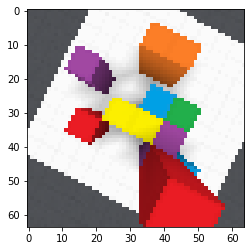

In [40]:
model.cpu()
for data in train_loader:
    tensor_image = data[2,:,:,:] / 255.
    plot_tensor(tensor_image)
    break

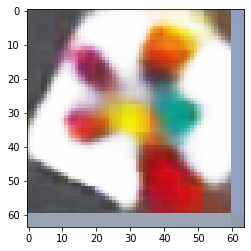

In [41]:
plot_tensor(model(tensor_image[None,:]).detach()[0])

## AliceCNN

In [42]:
class VisualEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=8, stride=4, padding=0),  
            nn.ELU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0), 
            nn.ELU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0), 
            nn.ELU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0),
            nn.ELU(), 
            nn.Conv2d(256, 1024, kernel_size=2, stride=1, padding=0),
            nn.ELU(),
            nn.Flatten(),
        )

    def forward(self, x):
        return self.cnn(x)

class VisualDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, kernel_size=2, stride=1, padding=0),
            nn.ELU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=0),
            nn.ELU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=0),
            nn.ELU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=0, output_padding=1),
            nn.ELU(),
            nn.ConvTranspose2d(32, 3, kernel_size=8, stride=4, padding=0),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.reshape(x.shape[0], 1024, 1, 1)
        x = self.cnn(x)
        return x 

class Autoencoder(nn.Module):
    def __init__(self,
               encoder_class : object = VisualEncoder,
               decoder_class : object = VisualDecoder):
        super().__init__()
        self.encoder = encoder_class()
        self.decoder = decoder_class()
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode
    
model = Autoencoder()
model.to('cuda')

total_params = sum(p.numel() for p in model.encoder.parameters() if p.requires_grad)
print('Total params:', total_params)

config_defaults = {
    'epochs': 100,
    'batch_size': 1024,
    'learning_rate': 1e-3,
    'optimizer': 'adam',
    'scheduler_step_size': 30,
    'scheduler_gamma': 0.5
}

wandb.init(project='AutoEncoder', entity='neuro_ai', name='AliceCNN', config=config_defaults)
config = wandb.config
optimizer = optim.Adam(model.parameters(), config.learning_rate)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=config.scheduler_step_size, 
                                            gamma=config.scheduler_gamma)

for epoch in range(config.epochs):
    #train
    model.train()
    train_loss = []
    for data in train_loader:
        data /= 255
        data = data.to('cuda')
        predict = model(data)
        loss = criterion(predict, data)    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    train_loss = np.array(train_loss).mean()
    
    #evaluate
    model.eval()
    val_loss = []
    for data in val_loader:
        data /= 255
        data = data.to('cuda')
        predict = model(data)
        loss = criterion(predict, data)
        val_loss.append(loss.item())
    val_loss = np.array(val_loss).mean()
    scheduler.step()
    wandb.log({"train_loss":train_loss, 'val_loss': val_loss})

torch.save(model.encoder.state_dict(), 'models/AliceCNN/encoder_weigths.pth')
torch.save(model.decoder.state_dict(), 'models/AliceCNN/decoder_weigths.pth')

Total params: 1457632


train_loss,0.01532
val_loss,0.01536


train_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


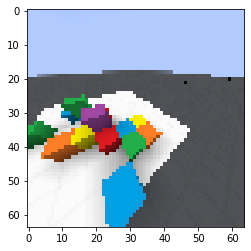

In [75]:
model.cpu()
for data in train_loader:
    tensor_image = data[2,:,:,:] / 255.
    plot_tensor(tensor_image)
    break

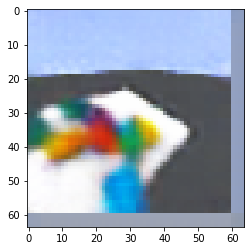

In [76]:
plot_tensor(model(tensor_image[None,:]).detach()[0])

## AngelaCNN

In [80]:
class VisualEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=2, stride=2, padding=0),  
            nn.ELU(),
            nn.Conv2d(32, 32, kernel_size=2, stride=2, padding=0), 
            nn.ELU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=2, padding=0), 
            nn.ELU(),
            nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=0),
            nn.ELU(), 
            nn.Conv2d(128, 256, kernel_size=2, stride=2, padding=0),
            nn.ELU(),
            nn.Conv2d(256, 512, kernel_size=2, stride=2, padding=0),
            nn.ELU(),
            nn.Flatten(),
        )

    def forward(self, x):
        return self.cnn(x)

class VisualDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0),
            nn.ELU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0),
            nn.ELU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0),
            nn.ELU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0),
            nn.ELU(),
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, padding=0),
            nn.ELU(),
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2, padding=0),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.reshape(x.shape[0], 512, 1, 1)
        x = self.cnn(x)
        return x 

class Autoencoder(nn.Module):
    def __init__(self,
               encoder_class : object = VisualEncoder,
               decoder_class : object = VisualDecoder):
        super().__init__()
        self.encoder = encoder_class()
        self.decoder = decoder_class()
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode
    
model = Autoencoder()
model.to('cuda')

total_params = sum(p.numel() for p in model.encoder.parameters() if p.requires_grad)
print('Total params:', total_params)

config_defaults = {
    'epochs': 100,
    'batch_size': 1024,
    'learning_rate': 1e-3,
    'optimizer': 'adam',
    'scheduler_step_size': 30,
    'scheduler_gamma': 0.5
}

wandb.init(project='AutoEncoder', entity='neuro_ai', name='AngelaCNN', config=config_defaults)
config = wandb.config
optimizer = optim.Adam(model.parameters(), config.learning_rate)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=config.scheduler_step_size, 
                                            gamma=config.scheduler_gamma)

for epoch in range(config.epochs):
    #train
    model.train()
    train_loss = []
    for data in train_loader:
        data /= 255
        data = data.to('cuda')
        predict = model(data)
        loss = criterion(predict, data)    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    train_loss = np.array(train_loss).mean()
    
    #evaluate
    model.eval()
    val_loss = []
    for data in val_loader:
        data /= 255
        data = data.to('cuda')
        predict = model(data)
        loss = criterion(predict, data)
        val_loss.append(loss.item())
    val_loss = np.array(val_loss).mean()
    scheduler.step()
    wandb.log({"train_loss":train_loss, 'val_loss': val_loss})

torch.save(model.encoder.state_dict(), 'models/AngelaCNN/encoder_weigths.pth')
torch.save(model.decoder.state_dict(), 'models/AngelaCNN/decoder_weigths.pth')

Total params: 701824


wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


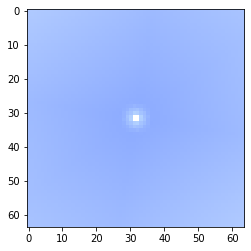

In [145]:
model.cpu()
for data in train_loader:
    tensor_image = data[2,:,:,:] / 255.
    plot_tensor(tensor_image)
    break

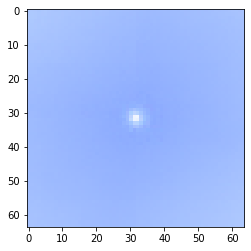

In [146]:
plot_tensor(model(tensor_image[None,:]).detach()[0])